In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import skimage.io as io
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os
import pickle
import pydicom

In [3]:
DATA_DIR = Path('input/rsna-breast-cancer-detection/')

In [4]:
train = pd.read_csv(DATA_DIR/'train.csv')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

In [6]:
train.describe()

,site_id,patient_id,image_id,age,cancer,biopsy,invasive,BIRADS,implant,machine_id
count,54706.000000,54706.000000,5.470600e+04,54669.000000,54706.000000,54706.000000,54706.000000,26286.000000,54706.000000,54706.000000
mean,1.460407,32698.865262,1.079386e+09,58.543928,0.021168,0.054272,0.014953,0.772350,0.026999,54.618378
std,0.498434,18893.861534,6.183269e+08,10.050884,0.143944,0.226556,0.121365,0.590062,0.162081,44.784800
min,1.000000,5.000000,6.849100e+04,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,1.000000,16481.000000,5.458153e+08,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000
50%,1.000000,32432.000000,1.082689e+09,59.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
75%,2.000000,48999.000000,1.613228e+09,66.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
max,2.000000,65534.000000,2.147472e+09,89.000000,1.000000,1.000000,1.000000,2.000000,1.000000,216.000000


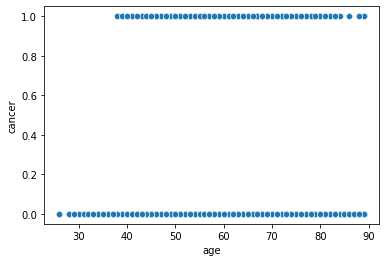

In [7]:
sns.scatterplot(x=train['age'], y=train['cancer'])
plt.show()

In [8]:
train['view'].value_counts()

MLO    27903
CC     26765
AT        19
LM        10
ML         8
LMO        1
Name: view, dtype: int64

In [9]:
train['difficult_negative_case'].value_counts()

False    47001
True      7705
Name: difficult_negative_case, dtype: int64

In [10]:
train.groupby('patient_id').agg({'cancer': 'sum'}).value_counts()

cancer
0         11427
2           343
3           107
4            29
5             7
dtype: int64

In [11]:
train.groupby('patient_id').agg({'image_id': 'count'}).value_counts()

image_id
4           8233
5           1767
6           1218
7            276
8            229
9             99
10            53
11            19
12            12
13             5
14             2
dtype: int64

In [14]:
train.groupby('patient_id').agg({'image_id': 'count'}).sort_values('image_id')

,image_id
patient_id,
5,4
39248,4
39252,4
39255,4
39261,4
...,...
5421,13
44047,13
9795,13


In [18]:
train.query('patient_id == 44047')

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
31754,1,44047,40147212,L,MLO,48.0,0,0,0,1.0,0,A,49,False
31755,1,44047,822072941,L,MLO,48.0,0,0,0,1.0,0,A,49,False
31756,1,44047,855155693,L,CC,48.0,0,0,0,1.0,0,A,49,False
31757,1,44047,1113266761,L,MLO,48.0,0,0,0,1.0,0,A,49,False
31758,1,44047,1624791783,L,CC,48.0,0,0,0,1.0,0,A,49,False
31759,1,44047,1731700724,L,CC,48.0,0,0,0,1.0,0,A,49,False
31760,1,44047,41014668,R,CC,48.0,0,0,0,1.0,0,A,49,False
31761,1,44047,409056837,R,MLO,48.0,0,0,0,1.0,0,A,49,False
31762,1,44047,432223802,R,MLO,48.0,0,0,0,1.0,0,A,49,False
31763,1,44047,541390054,R,MLO,48.0,0,0,0,1.0,0,A,49,False


In [12]:
train2 = train.merge(train.groupby('patient_id').agg({'image_id': 'count'}).reset_index(), on='patient_id', suffixes=['', '_count'])
train2.query('cancer == 0')['image_id_count'].mean(), train2.query('cancer == 1')['image_id_count'].mean()

(4.870079181295287, 4.949050086355786)

In [13]:
train2.query('cancer == 1')

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_id_count
87,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False,7
88,1,10130,613462606,L,CC,71.0,1,1,1,0.0,0,B,49,False,7
89,1,10130,1360338805,L,CC,71.0,1,1,1,0.0,0,B,49,False,7
90,1,10130,1672636630,L,MLO,71.0,1,1,1,0.0,0,B,49,False,7
190,1,10226,461614796,L,MLO,71.0,1,1,1,0.0,0,C,49,False,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54485,2,9707,1900919592,R,MLO,56.0,1,1,1,NaN,0,NaN,21,False,4
54593,2,9840,111786935,R,MLO,59.0,1,1,1,NaN,0,NaN,21,False,4
54594,2,9840,1559360810,R,CC,59.0,1,1,1,NaN,0,NaN,21,False,4
54595,2,9851,1409270544,L,MLO,58.0,1,1,0,NaN,0,NaN,48,False,4


In [14]:
train.groupby(['patient_id', 'laterality']).agg({'cancer': 'std'}).value_counts() # No label dismatch with LR 


cancer
0.0       23826
dtype: int64

In [15]:
train['difficult_negative_case'] = train['difficult_negative_case'].astype(np.uint8)

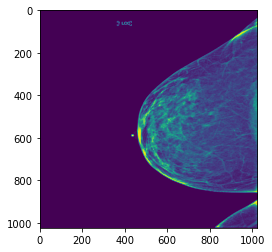

In [29]:
# sample_image = cv2.imread('input/rsna-breast-cancer-detection/image_resized_1024W/1342/1032595121.png')
sample_image = cv2.imread('input/rsna-breast-cancer-detection/image_resized_1024W/448/770375689.png')
# sample_image = cv2.imread('input/rsna-breast-cancer-detection/image_resized_1024W/33/1863578666.png')
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)
plt.imshow(sample_image)

In [104]:
def crop_roi(img, threshold=0.5, buffer=50):
    y_max, x_max = img.shape
    img2 = img > img.mean()
    y_mean = img2.mean(0)
    x_mean = img2.mean(1)
    x_mean[:buffer] = 0
    x_mean[-buffer:] = 0
    y_mean[:buffer] = 0
    y_mean[-buffer:] = 0
    y_mean = (y_mean - y_mean.min()) / (y_mean.max() - y_mean.min())
    x_mean = (x_mean - x_mean.min()) / (x_mean.max() - x_mean.min())
    plt.plot(y_mean)
    plt.plot(x_mean)
    plt.show()
    y_slice = np.where(y_mean > threshold)[0]
    x_slice = np.where(x_mean > threshold)[0]
    if len(x_slice) == 0:
        x_start, x_end = 0, x_max
    else:
        x_start, x_end = max(x_slice.min() - buffer, 0), min(x_slice.max() + buffer, x_max)
    if len(y_slice) == 0:
        y_start, y_end = 0, y_max
    else:
        y_start, y_end = max(y_slice.min() - buffer, 0), min(y_slice.max() + buffer, y_max)
    return img[x_start:x_end, y_start:y_end]

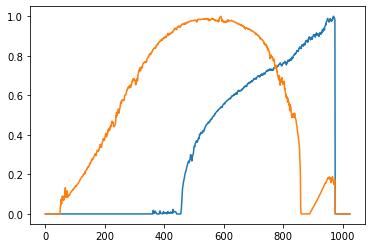

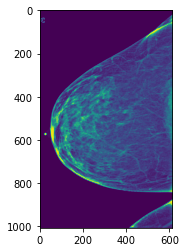

In [105]:
plt.imshow(crop_roi(sample_image, threshold=0.1))

# Dataset

In [32]:
from datasets import *
from architectures import MultiViewModel, MultiInstanceModel, MultiLevelModel
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
from transforms import *
from configs import *

In [33]:
cfg = Model05v2()
ds = PatientLevelDataset(
    df=train, image_dir=Path('input/rsna-breast-cancer-detection/image_resized_1024W'),
    flip_lr=False, sample_num=1,
    is_test=True,
    preprocess=A.Compose([AutoFlip(), CropROI(threshold=0.1, buffer=160), A.Resize(768, 384)]),
    transforms=ToTensorV2(),
    # preprocess=cfg.preprocess['train'],
    # transforms=cfg.transforms['train']
)

In [34]:
# for i in tqdm(range(1000)):
#     img, label = ds[i]

In [35]:
ds.df_dict[ds.pids[160]]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
32453,1,448,770375689,L,CC,40.0,0,0,0,1.0,0,C,49,False
32454,1,448,1495871190,L,MLO,40.0,0,0,0,1.0,0,C,49,False


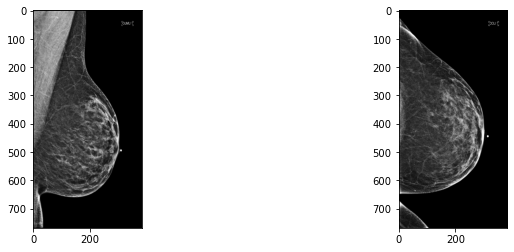

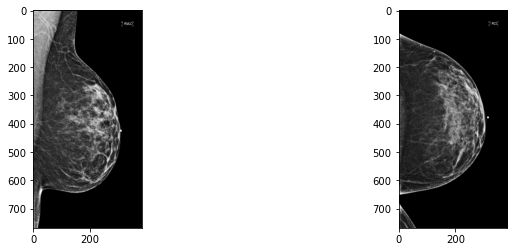

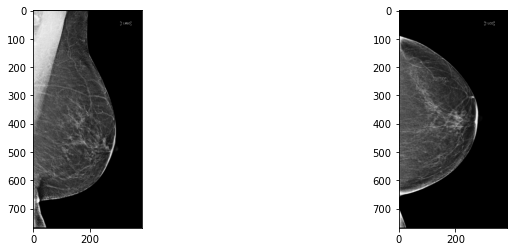

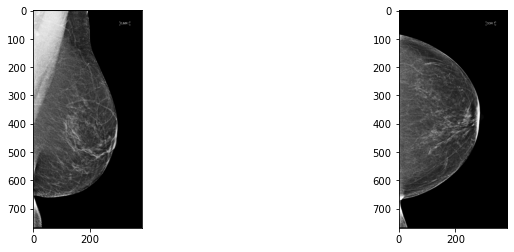

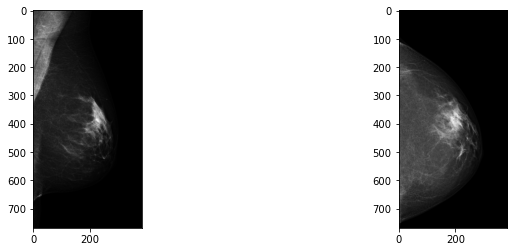

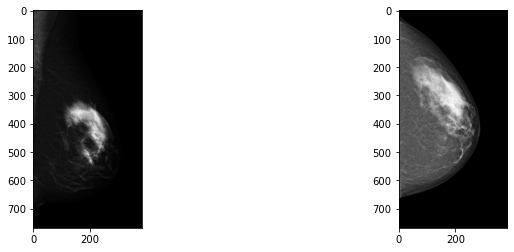

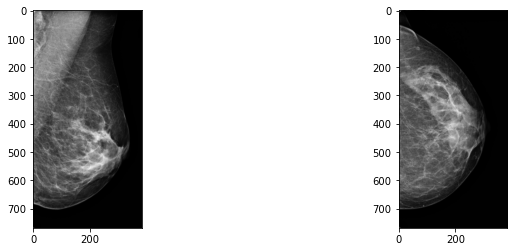

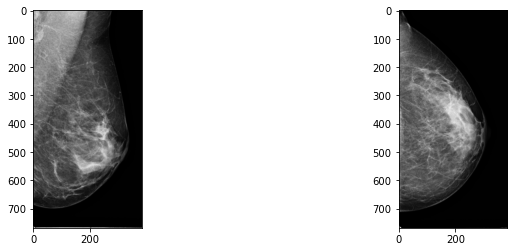

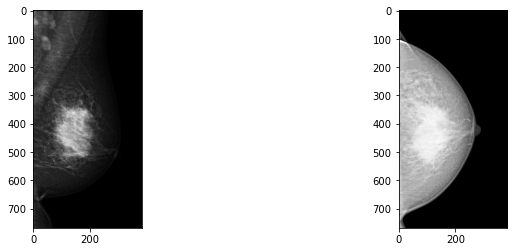

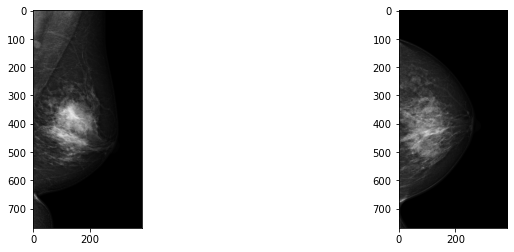

In [40]:
for i in np.arange(160, 170):
# for i in np.arange(0, 10001, 2000):
    img, label = ds[i]
    img = (img - img.min()) / (img.max() - img.min())
    plt.figure(figsize=(12, 4))
    for i in range(img.shape[0]):
        plt.subplot(1, img.shape[0], i+1)
        plt.imshow(img[i, 0], cmap='gray')
    plt.show()
    # plt.savefig(f'input/plot/{i}.png', facecolor='white')
    plt.close()

In [32]:
ds = PatientLevelDataset(
    df=train, image_dir=Path('input/rsna-breast-cancer-detection/image_resized_1024'),
    preprocess=ImageToTile(tile_size=256, num_tiles=16, criterion='brightness', concat=False, dropout=0.1),
    transforms=ToTensorV2()
)
img, label = ds[2]
img.shape

torch.Size([2, 16, 1, 256, 256])

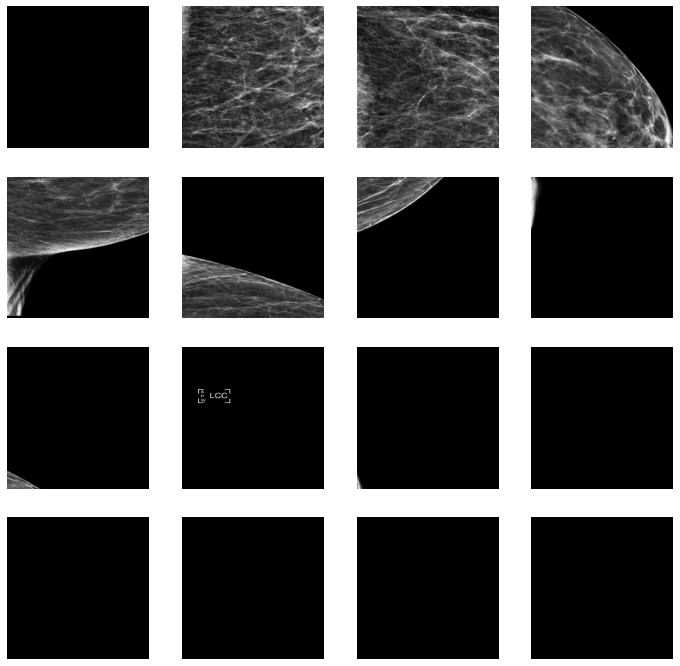

In [20]:
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(img[1, i, 0], cmap='gray')
    plt.axis('off')
plt.show()

In [16]:
# model = MultiInstanceModel()
# with torch.no_grad():
#     print(model(img[None, :, :, :, :, :].float()))

In [7]:
cfg = Model06()
# cfg.model_params['classification_model'] = 'vit_tiny_patch16_384.augreg_in21k_ft_in1k'
model = cfg.model(**cfg.model_params)

In [8]:
import torchsummary

In [11]:
_ = torchsummary.summary(model, (4, 1, 1024, 512), device='cpu')

Layer (type:depth-idx)                        Output Shape              Param #
├─ConvNeXt: 1-1                               [-1, 768, 32, 16]         --
|    └─Sequential: 2-1                        [-1, 96, 256, 128]        --
|    |    └─Conv2d: 3-1                       [-1, 96, 256, 128]        1,632
|    |    └─LayerNorm2d: 3-2                  [-1, 96, 256, 128]        192
|    └─Sequential: 2-2                        [-1, 768, 32, 16]         --
|    |    └─ConvNeXtStage: 3-3                [-1, 96, 256, 128]        237,888
|    |    └─ConvNeXtStage: 3-4                [-1, 192, 128, 64]        992,256
|    |    └─ConvNeXtStage: 3-5                [-1, 384, 64, 32]         32,747,520
|    |    └─ConvNeXtStage: 3-6                [-1, 768, 32, 16]         15,470,592
|    └─Identity: 2-3                          [-1, 768, 32, 16]         --
|    └─Sequential: 2                          []                        --
|    |    └─SelectAdaptivePool2d: 3-7         [-1, 768, 32, 16]  